In [ ]:
import pandas as pd        
import pygam
from pygam import ExpectileGAM
from matplotlib import pyplot as plt
#from pygam.datasets import mcycle
#from sklearn.datasets import load_boston
#boston = load_boston()
df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv").set_index('States')

target = "Poverty"
y = df[[target]]
X = df.loc[:, ~df.columns.isin(["States",target])].copy()

import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#X = df[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
#y = target_df


In [ ]:
gam = pygam.LinearGAM(n_splines=10).gridsearch(X_train.values, y_train.values)

In [ ]:
gam.summary()

In [ ]:
gam50 = ExpectileGAM(expectile=0.5).gridsearch(X_train.values, y_train.values)
lam = gam50.lam
gam95 = ExpectileGAM(expectile=0.95, lam=lam).fit(X_train.values, y_train.values)
gam75 = ExpectileGAM(expectile=0.75, lam=lam).fit(X_train.values, y_train.values)
gam25 = ExpectileGAM(expectile=0.25, lam=lam).fit(X_train.values, y_train.values)
gam05 = ExpectileGAM(expectile=0.05, lam=lam).fit(X_train.values, y_train.values)

In [ ]:
#XX = gam.generate_X_grid(gam)
XX = gam50.generate_X_grid(term=0, n=500)

In [ ]:
XX

In [ ]:
#ExpectileGAM(expectile=0.5).gridsearch(X, y)
#XX = gam.generate_X_grid(gam)
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(X.columns))
titles = X.columns
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-100,100)
    ax.set_title(titles[i])    
fig

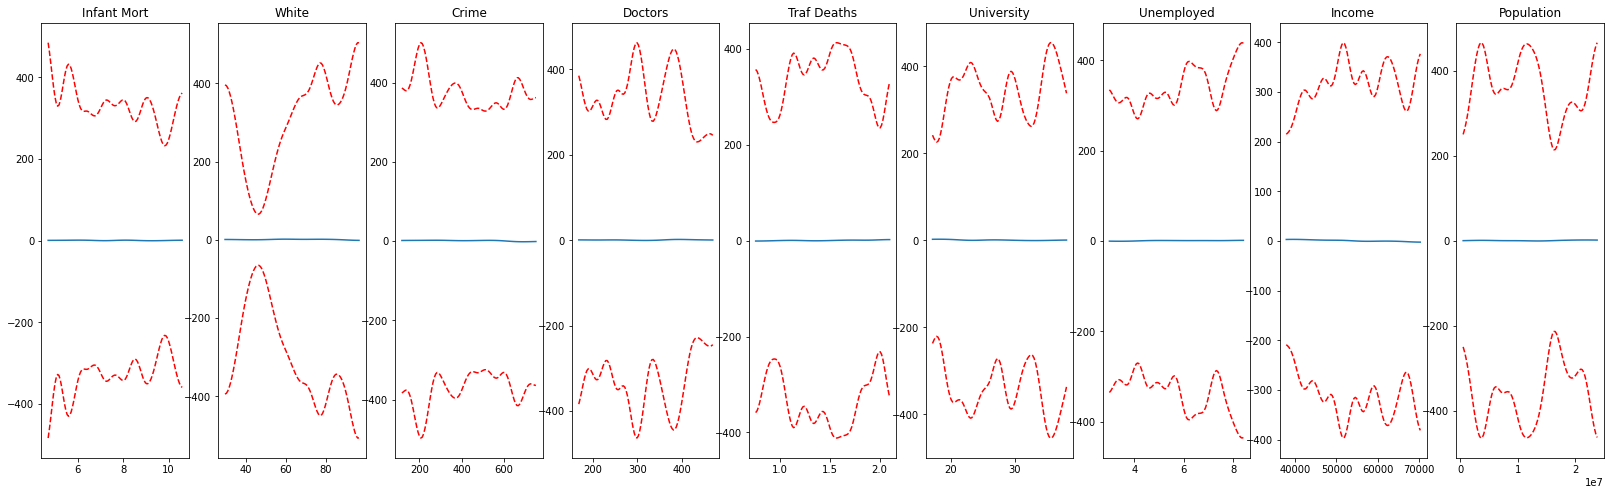

In [59]:
fig